# Project 242

## Import

In [258]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [259]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [260]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


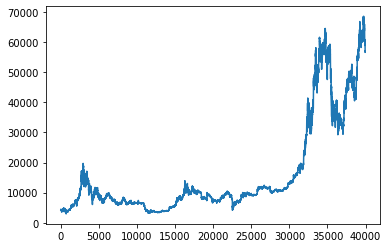

In [261]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [262]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [263]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [264]:
data = data.drop(['VWAP'], axis = 1)

In [265]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [266]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [267]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [268]:
# Add Signal
q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, q_90)
test_data = add_signal(test_data, q_90)

In [269]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (5.0%) | 0 (90.0%) | -1 (5.0%)
Test set: 1 (6.0%) | 0 (88.0%) | -1 (6.0%)


In [270]:
#display(train_data.head(2))
#display(test_data.head(2))

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [271]:
train = prepare_data_2D_format(train_data)
train.head()

NameError: name 'prepare_data_2D_format' is not defined

In [195]:
X_train, y_train, return_train = prepare_data_for_training(train_data, lookback_period=10, signal = True)
X_test, y_test, return_test = prepare_data_for_training(test_data, lookback_period=10, signal = True)

y_train = y_train[10:]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


In [196]:
## Remove empty lists in the beginning
while len(X_train[0]) == 0:
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) == 0:
    X_test = X_test[1:]
    y_test = y_test[1:]

In [197]:
from tqdm import tqdm
def format_2D(arr):
    res = []
    for item in arr:
        features = []
        for day in item:
            features += day.tolist()
        res.append(features)
    return res
X_train = format_2D(X_train)
X_test = format_2D(X_test)

In [198]:
## Some indicators have a larger lookback period than other. 
## We remove the beginning of the dataset to make everything homogeneous

while len(X_train[0]) != 10*len(data.columns):
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) != 10*len(data.columns):
    X_test = X_test[1:]
    y_test = y_test[1:]
    
X_train = np.array(X_train)
X_test = np.array(X_test)

### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [199]:
features = []
for k in range(10):
    features = features + [col+"_day_minus"+str(10-k) for col in data.columns]

In [200]:
train = pd.DataFrame(X_train)
train.columns = features
train['Signal'] = pd.Series(y_train)

test = pd.DataFrame(X_test)
test.columns = features
test['Signal'] = pd.Series(y_test)

In [201]:
str_formula = 'Signal ~ '
for feat in features:
    str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [202]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.223
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           2.52e-11
Time:                        11:18:48   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.587e+04
Df Residuals:                   29794   BIC:                         1.671e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

We perform feature selection using the p-value

In [203]:
## remove high_day_minus4:
removed = ['high_day_minus4']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.246
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.66e-11
Time:                        11:18:49   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29795   BIC:                         1.670e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [204]:
## remove Volume_day_minus2:
removed = ['high_day_minus4', 'Volume_day_minus2']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.268
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.09e-11
Time:                        11:18:51   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29796   BIC:                         1.669e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [205]:
## remove Volume_day_minus8:
removed = ['high_day_minus4', 'Volume_day_minus2', 'Volume_day_minus8']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.292
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           7.16e-12
Time:                        11:18:52   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29797   BIC:                         1.668e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [206]:
## remove MOM_day_minus6:
removed.append('MOM_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.292
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           7.16e-12
Time:                        11:18:54   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29797   BIC:                         1.668e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [207]:
## remove MACD_day_minus6:
removed.append('MACD_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.315
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           4.66e-12
Time:                        11:18:55   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29798   BIC:                         1.667e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [208]:
## remove high_day_minus3:
removed.append('high_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.339
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.02e-12
Time:                        11:18:56   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29799   BIC:                         1.666e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [209]:
## remove close_day_minus3:
removed.append('close_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.339
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.02e-12
Time:                        11:18:58   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29799   BIC:                         1.666e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [210]:
## remove EMA_day_minus10
removed.append('EMA_day_minus10')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.339
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.02e-12
Time:                        11:19:00   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29799   BIC:                         1.666e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [211]:
## remove EMA_day_minus9:
removed.append('EMA_day_minus9')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.339
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.02e-12
Time:                        11:19:02   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.586e+04
Df Residuals:                   29799   BIC:                         1.666e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0088    

In [212]:
## remove all EMAs
## EMAs are computed in a recurrent way, which is why they are so highly correlated
removed.append('EMA_day_minus8')
removed.append('EMA_day_minus7')
removed.append('EMA_day_minus6')
removed.append('EMA_day_minus5')
removed.append('EMA_day_minus4')
removed.append('EMA_day_minus3')
removed.append('EMA_day_minus2')
removed.append('EMA_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.389
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.25e-12
Time:                        11:19:04   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.585e+04
Df Residuals:                   29801   BIC:                         1.664e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0093    

In [213]:
## remove close_day_minus5
removed.append('close_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.415
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           7.98e-13
Time:                        11:19:06   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.585e+04
Df Residuals:                   29802   BIC:                         1.663e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0092    

In [214]:
## remove RSI_day_minus5
removed.append('RSI_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.441
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           5.07e-13
Time:                        11:19:09   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.585e+04
Df Residuals:                   29803   BIC:                         1.662e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0092    

In [215]:
## remove RSI_day_minus1
removed.append('RSI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.468
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.21e-13
Time:                        11:19:12   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.585e+04
Df Residuals:                   29804   BIC:                         1.661e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0097    

In [216]:
## remove high_day_minus2
removed.append('high_day_minus2')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.495
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           2.02e-13
Time:                        11:19:14   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.584e+04
Df Residuals:                   29805   BIC:                         1.660e+04
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0096    

In [217]:
## remove CCI_day_minus1
removed.append('CCI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.523
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.26e-13
Time:                        11:19:15   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.584e+04
Df Residuals:                   29806   BIC:                         1.659e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0096    

In [218]:
## remove BB_low_day_minus3
removed.append('BB_low_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.551
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           7.94e-14
Time:                        11:19:17   Log-Likelihood:                -7831.2
No. Observations:               29896   AIC:                         1.584e+04
Df Residuals:                   29807   BIC:                         1.658e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0097    

In [219]:
y_prob = reg.predict(test)

p75 = y_prob.mean() + y_prob.std()/3
p25 = y_prob.mean() - y_prob.std()/3
def classifier(x):
    ''' Use the distribution of y_prob to define the classifier'''
    if x < p25: return -1
    if x > p75: return 1
    return 0
y_pred = [classifier(x) for x in y_prob]
freq = {'1': len([x for x in y_pred if x == 1]), 
        '-1': len([x for x in y_pred if x == -1]), 
        '0': len([x for x in y_pred if x == 0])}
print(freq)

{'1': 3005, '-1': 3227, '0': 3736}


### 3. Test prediction model

In [220]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [221]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.38132,0,0


### III. Strategy

### 1. Get data ready for backtesting

In [222]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [223]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9968.000000
mean       -0.022271
std         0.790422
min        -1.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64

In [224]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [225]:
strat = Strategy(cash=500, fees=0.001)

In [226]:
strat.run(signal_crop, close_crop, verbose=False)

In [227]:
wallet = np.array(strat.wallet)
profit = wallet[:-1] - wallet[1:]

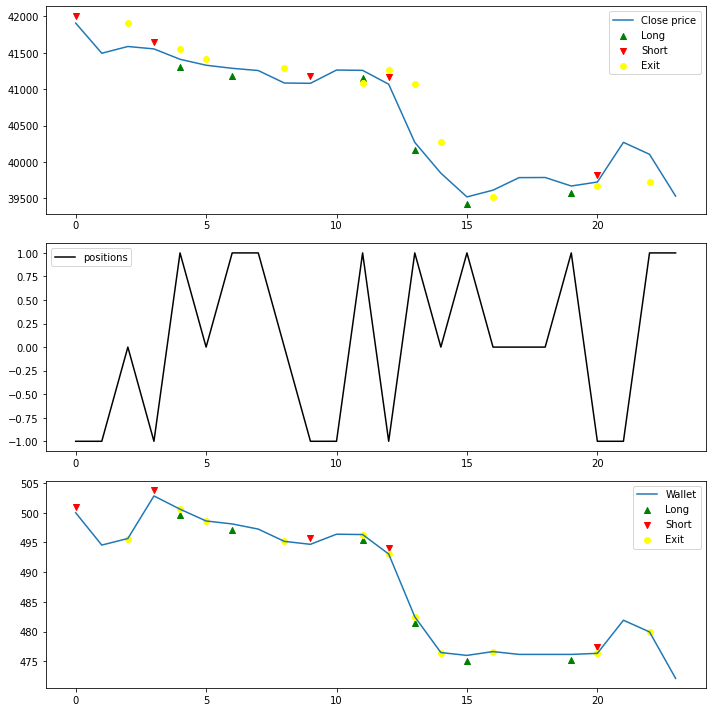

In [228]:
strat.visualize()

### 3. Test performance startegy

In [229]:
SharpeRatio = SharpeRatio(profit)
MaxDrawback = MaxDrawback(profit)
WinLossRatio = WinLossRatio(profit)
CumulativeProfit = CumulativeProfit(profit)
MeanProfit = MeanProfit(profit)

In [230]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[SharpeRatio, MaxDrawback, WinLossRatio, CumulativeProfit, MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,0.316776,-7.165198,2.5,27.885505,1.161896
